In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import models, transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm

DATA_DIR = "../content/processed_data"
BATCH_SIZE = 32
EPOCHS = 10  # Epochs per fold
K_FOLDS = 5  # As requested in the document 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASSES = ["Hemorrhagic", "Ischemic", "Tumor"]


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Helper to create double convolutions
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        # Encoder (Downsampling)
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)

        # Decoder (Upsampling)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(64 + 128, 64)
        
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1) # Output: 1 channel (Binary Mask)

    def forward(self, x):
        # Down
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_down4(x)
        
        # Up
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1) # Skip connection
        x = self.dconv_up3(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1) # Skip connection
        x = self.dconv_up2(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1) # Skip connection
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        return torch.sigmoid(out) # Output 0-1 probability map

# Check
unet_model = UNet().to(DEVICE)
print("U-Net Architecture Ready.")

U-Net Architecture Ready.


In [11]:
from sklearn.cluster import KMeans

def generate_pseudo_mask(image_tensor, label_idx):
    """
    Auto-generates a mask for training U-Net without manual labels.
    Uses K-Means to isolate the lesion based on intensity.
    """
    # 1. Convert Tensor to Numpy Image (Grayscale)
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    
    # Undo normalization to get real pixel values (0-1 range)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    gray = cv2.cvtColor(np.float32(img_np), cv2.COLOR_RGB2GRAY)
    
    # 2. Get Mask of Brain Tissue (Ignore black background)
    brain_mask = gray > 0.05
    pixels = gray[brain_mask].reshape(-1, 1)
    
    if len(pixels) < 100: return np.zeros_like(gray) # Safety check
    
    # 3. K-Means Clustering (k=3: Dark, Mid, Bright)
    kmeans = KMeans(n_clusters=3, n_init=5, random_state=42)
    labels = kmeans.fit_predict(pixels)
    centers = kmeans.cluster_centers_.flatten()
    
    # Sort clusters by brightness
    sorted_indices = np.argsort(centers)
    darkest_cluster = sorted_indices[0]
    brightest_cluster = sorted_indices[2]
    
    # 4. Create Lesion Mask
    mask_flat = np.zeros_like(labels)
    
    # LOGIC:
    # Hemorrhage (0) & Tumor (2) -> Usually Bright (Hyperdense/Enhanced)
    # Ischemic (1) -> Usually Dark (Hypodense)
    
    target_cluster = brightest_cluster if label_idx != 1 else darkest_cluster
    
    mask_flat[labels == target_cluster] = 1
    
    # Reconstruct 2D mask
    full_mask = np.zeros_like(gray)
    full_mask[brain_mask] = mask_flat
    
    # Clean up noise (Morphology)
    kernel = np.ones((3,3), np.uint8)
    full_mask = cv2.morphologyEx(full_mask.astype(np.float32), cv2.MORPH_OPEN, kernel)
    
    return torch.tensor(full_mask, dtype=torch.float32).unsqueeze(0) # (1, 224, 224)

print("Pseudo-Mask Generator Ready.")

Pseudo-Mask Generator Ready.


In [12]:
# Define Standard Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
class NeuroDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_map = {name: i for i, name in enumerate(CLASSES)}
        
        # Load all images
        for cls_name in CLASSES:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.exists(cls_folder): continue
            
            fnames = [f for f in os.listdir(cls_folder) if f.endswith(('.jpg', '.png'))]
            for f in fnames:
                self.samples.append((os.path.join(cls_folder, f), self.class_map[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [14]:
# Initialize Dataset
full_dataset = NeuroDataset(DATA_DIR, transform=transform)
print(f"Dataset Loaded: {len(full_dataset)} total images.")

Dataset Loaded: 6216 total images.


In [15]:
def train_segmentation(dataset, epochs=5):
    unet = UNet().to(DEVICE)
    optimizer = optim.Adam(unet.parameters(), lr=0.001)
    criterion = nn.BCELoss() # Binary Cross Entropy
    
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    
    print("Starting U-Net Training (Self-Supervised)...")
    
    for epoch in range(epochs):
        unet.train()
        train_loss = 0.0
        
        for images, labels in tqdm(loader, desc=f"Seg Epoch {epoch+1}", leave=False):
            images = images.to(DEVICE)
            
            # Generate Target Masks on the fly
            masks = []
            for i in range(len(images)):
                mask = generate_pseudo_mask(images[i], labels[i].item())
                masks.append(mask)
            masks = torch.stack(masks).to(DEVICE)
            
            # Forward
            optimizer.zero_grad()
            outputs = unet(images)
            
            # Loss
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        print(f"Epoch {epoch+1} Segmentation Loss: {train_loss/len(loader):.4f}")
        
    # Save
    torch.save(unet.state_dict(), "unet_lesion_model.pth")
    return unet

# Run Training (Takes ~5-10 mins)
unet_model = train_segmentation(full_dataset, epochs=5)

Starting U-Net Training (Self-Supervised)...


Epoch 1 Segmentation Loss: 0.1750


Epoch 2 Segmentation Loss: 0.1266


Epoch 3 Segmentation Loss: 0.1146


Epoch 4 Segmentation Loss: 0.1034


Epoch 5 Segmentation Loss: 0.0951


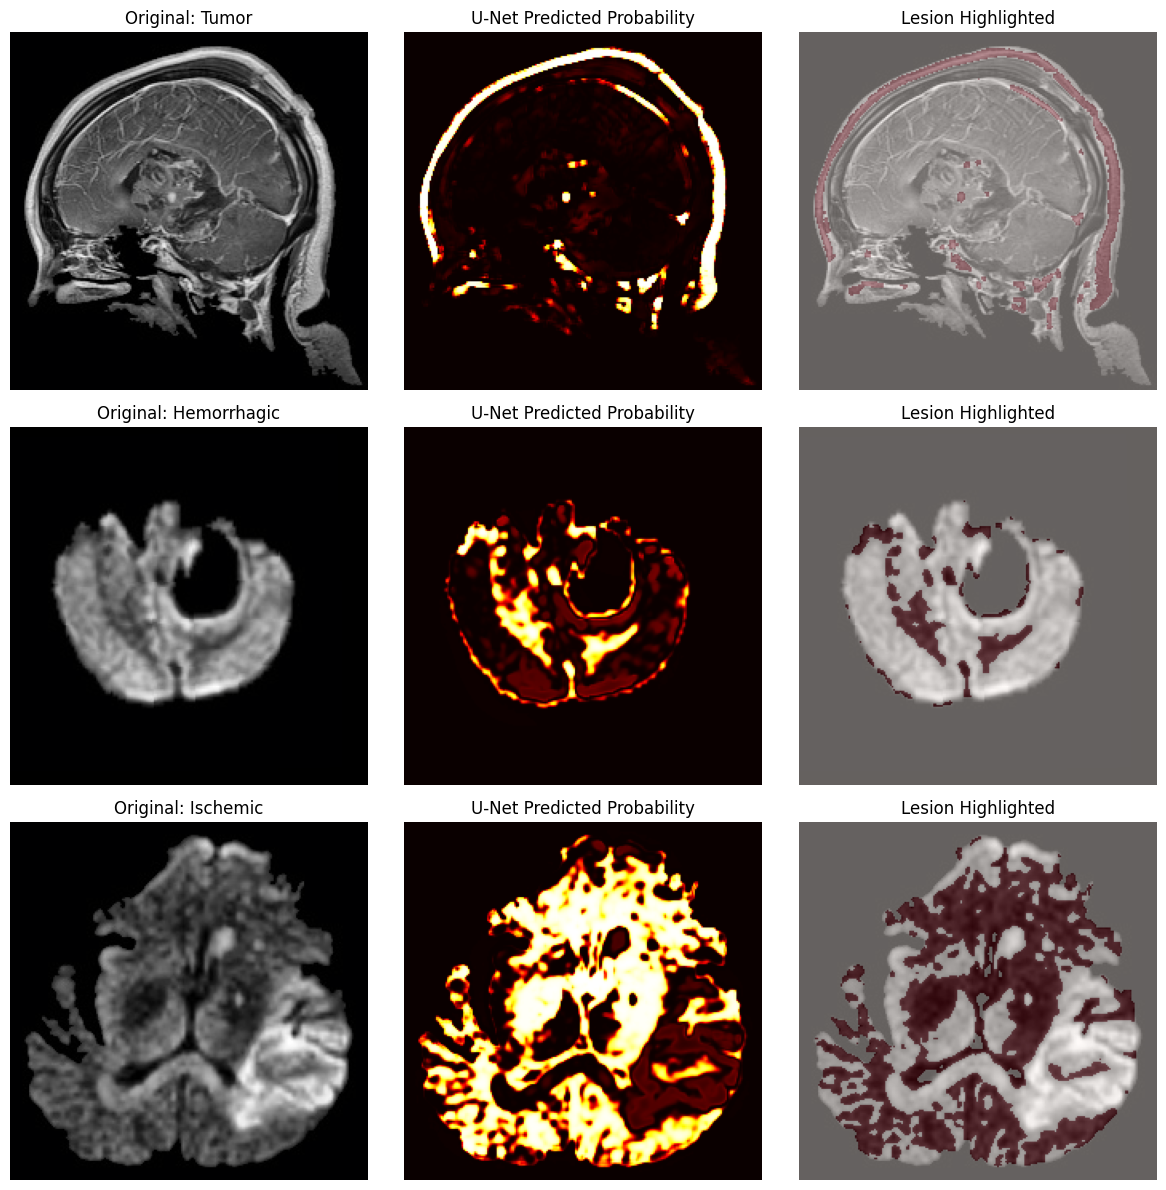

In [19]:
def visualize_segmentation_results(model, dataset, num_samples=3):
    model.eval()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    plt.figure(figsize=(12, 4 * num_samples))
    
    for i, idx in enumerate(indices):
        image_tensor, label_idx = dataset[idx]
        input_tensor = image_tensor.unsqueeze(0).to(DEVICE)
        
        # Predict Mask
        with torch.no_grad():
            pred_mask = model(input_tensor)
            pred_mask = pred_mask.cpu().squeeze().numpy()
        
        # Threshold (Make it binary)
        pred_mask_bin = (pred_mask > 0.5).astype(np.float32)
        
        # Prepare Image
        img_disp = image_tensor.permute(1, 2, 0).numpy()
        img_disp = img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_disp = np.clip(img_disp, 0, 1)
        
        # Plot
        # 1. Original
        ax1 = plt.subplot(num_samples, 3, i*3 + 1)
        ax1.imshow(img_disp)
        ax1.set_title(f"Original: {CLASSES[label_idx]}")
        ax1.axis('off')
        
        # 2. U-Net Mask
        ax2 = plt.subplot(num_samples, 3, i*3 + 2)
        ax2.imshow(pred_mask, cmap='hot')
        ax2.set_title("U-Net Predicted Probability")
        ax2.axis('off')
        
        # 3. Overlay
        ax3 = plt.subplot(num_samples, 3, i*3 + 3)
        ax3.imshow(img_disp)
        ax3.imshow(pred_mask_bin, cmap='Reds', alpha=0.4) # Red overlay
        ax3.set_title("Lesion Highlighted")
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Run
visualize_segmentation_results(unet_model, full_dataset)